# Heath–Jarrow–Morton model
The Heath-Jarrow-Morton (HJM) model is a framework for modeling the term structure of interest rates. As a multi-factor model, it describes the evolution of the entire yield curve over time. The HJM model is commonly used for pricing interest rate derivatives and managing interest rate risk. Unlike short-rate models, which focus on the interest rate at a specific point in time, the HJM model accounts for the entire yield curve. To ensure consistency, the model is calibrated using the current yield curve as its input.

## Theoretical result

The key result of the HJM model is that the forward rate curve is driven by the volatility of the instantaneous forward rate.

We introduce the following notation:
- $P(t,T)$: the price at time t of a risk-free zero-coupon bond with principal 1 and maturity T
- $\Omega_t$: vector of past and present values of interest rates and bond prices at time $t$ that are relevant for determining bond price volatilities at that time
- $v(t,T,\Omega_t)$: the volatility of $P(t,T)$
- $f(t, T_1, T_2)$: the forward rate at time $t$ for the period $[T_1, T_2]$
- $F(t,T)$: the instantaneous forward rate at time $t$ for a contract maturing at time $T$
- $dz(t)$: the increment of the Wiener process at time $t$ driving the term structure

For simplicity, we assume there is only one source of randomness in the model, the Wiener process $dz(t)$. The case of multiple sources of randomness can easily be derived from this case. We use the traditional risk-neutral world.

The risk-free zero-coupon bond price $P(t,T)$ satisfies the following stochastic differential equation:
$$dP(t,T) = P(t,T) r(t) dt + P(t,T) v(t,T,\Omega_t) dz(t)$$

As the price of a bond tends to its principal at maturity, we have $\forall t, v(t,t,\Omega_t) = 0$. This condition is equivalent to the fact that a bond has finite drift at all times (otherwise, its price could be very far from its principal even very close to maturity).

By definition, the forward rate $f(t,T_1,T_2)$ is: 
$$f(t,T_1,T_2) = \frac{\ln(P(t,T_1)) - \ln(P(t,T_2))}{T_2 - T_1}$$

Applying Itô's lemma to $\ln(P(t,T))$ gives:
$$d\ln(P(t,T)) = \left( r(t) - \frac{v(t,T,\Omega_t)^2}{2} \right) dt + v(t,T,\Omega_t) \ dz(t)$$

Therefore, the forward rate $f(t,T_1,T_2)$ satisfies the following stochastic differential equation:
$$df(t,T_1,T_2) = \frac{v(t,T_2,\Omega_t)^2 - v(t,T_1,\Omega_t)^2}{2 (T_2 - T_1)} \ dt + \frac{v(t,T_1,\Omega_t) - v(t,T_2,\Omega_t)}{T_2 - T_1} \ dz(t)$$

Taking $T_1=T$ and $T_2=T+dt$ with $dt$ tending to $0$, $f(t,T,T+dt)$ tends to the instantaneous forward rate $F(t,T)$ and by noting that $$\frac{1}{2} \frac{\partial [v(t,T,\Omega_t)^2]}{\partial T} = \frac{\partial v(t,T,\Omega_t)}{\partial T} v(t,T,\Omega_t)$$
we get:
$$dF(t,T) = \frac{\partial v(t,T,\Omega_t)}{\partial T} v(t,T,\Omega_t) \ dt + \frac{\partial v(t,T,\Omega_t)}{\partial T} \ dz(t)$$

By integrating $\frac{\partial v(t,\tau,\Omega_t)}{\tau}$ between $t$ and $T$, we get:
$$v(t,T,\Omega_t) = v(t,t,\Omega_t) + \int_t^T \frac{\partial v(t,\tau,\Omega_t)}{\partial \tau} d\tau$$
$$v(t,T,\Omega_t) = \int_t^T \frac{\partial v(t,\tau,\Omega_t)}{\partial \tau} d\tau$$
because $v(t,t,\Omega_t) = 0$.

By noting the standard deviation of $F(t,T)$ as $s(t,T,\Omega_t) = \frac{\partial v(t,T,\Omega_t)}{\partial T}$, we have:
$$dF(t,T) = s(t,T,\Omega_t) \int_t^T s(t,\tau,\Omega_t) d\tau \ dt + s(t,T,\Omega_t) \ dz(t)$$

This is the HJM result. It states that the instantaneous forward rate is driven by the volatility of the instantaneous forward rate.
The presence of $\Omega_t$ in the result shows that the process for any forward rate (including the short rate $F(t,t)$) is non-Markov. This makes the general HJM model complex and a Monte Carlo simulation has to be used. Assumptions on $s(t,T,\Omega_t)$ can make the process Markov and lead to Ho-Lee and Hull-White models.

## Practice

We are going to use a principal component analysis to identify the key factors that drive movements in rates. Then, we use an interpolator to fit these factors and these interpolators are used to generate forward rates in Monte Carlo simulations.

In [1]:
import pandas_datareader as pdr
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use("dark_background")
import numpy as np
import copy as copylib

We use a built-in function from the pandas_datareader module to get data on US treasury yields.

In [26]:
start = datetime(2010, 1, 1)
end = datetime(2016, 1, 1)

dict_maturities={}
maturities = [1/12, 0.25, 0.5,1,2,3,5,7,10,20,30]
for i in maturities:
    if(i<1):
        dict_maturities[str(int(i*12))+'M']='DGS'+str(int(i*12))+'MO'
    else:
        dict_maturities[str(i)+'Y']='DGS'+str(i)

data = pd.DataFrame()
for key, series_id in dict_maturities.items():
    data[key] = pdr.get_data_fred(series_id, start, end)
data = data.dropna()/100    #we delete the dates with missing values and convert to percentage

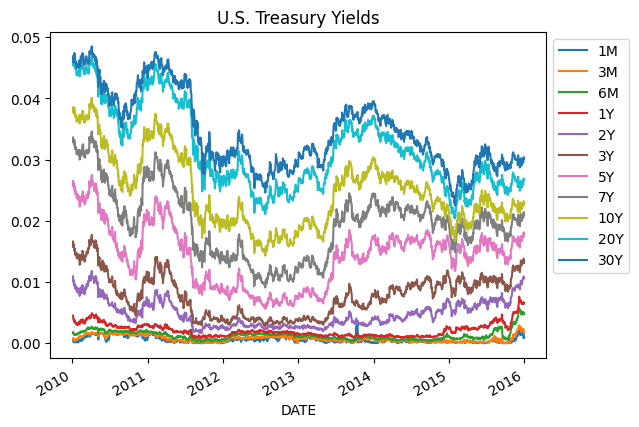

In [27]:
data.plot(title='U.S. Treasury Yields')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

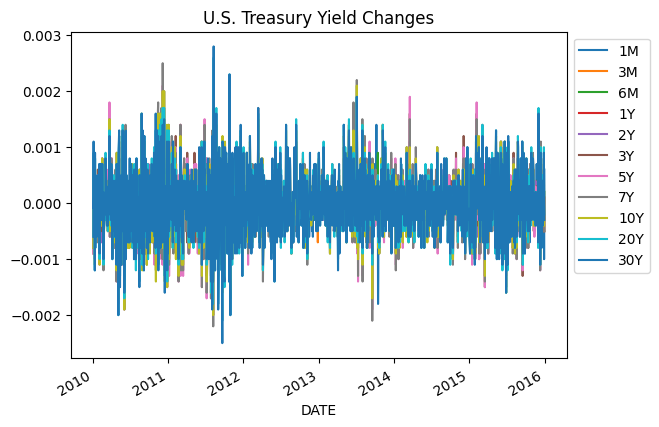

In [28]:
diff = data.diff().dropna()
diff.plot(title='U.S. Treasury Yield Changes')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

We calculate the covariance matrix, its eigenvectors and eigenvalues and we keep the highest principal components. 

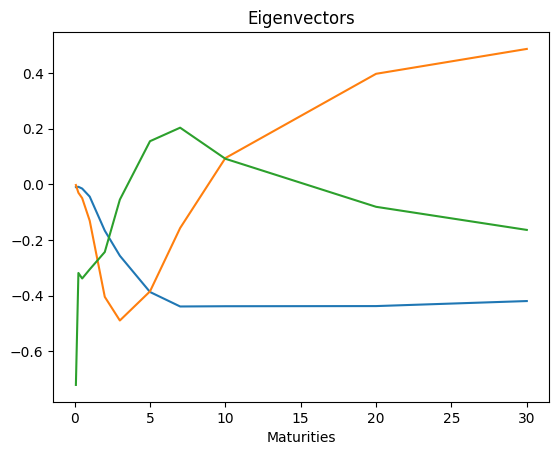

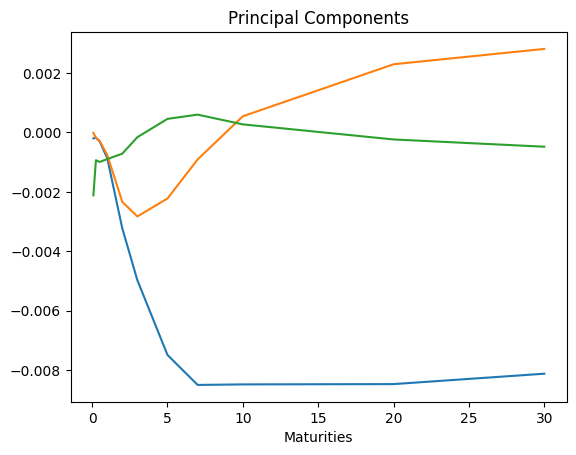

In [29]:
sigma = diff.cov() * 252
eigvals, eigvecs = np.linalg.eig(sigma)
nb_components_kept = 3
eigvals = eigvals[:nb_components_kept]
eigvecs = eigvecs[:,:nb_components_kept]
plt.plot(maturities, eigvecs)
plt.title('Eigenvectors')
plt.xlabel('Maturities')
plt.show()
sqrt_eigvals = np.sqrt(eigvals)
vols = np.dot(eigvecs, np.diag(sqrt_eigvals))
plt.plot(maturities, vols)
plt.title("Principal Components")
plt.xlabel('Maturities')
plt.show()

We create a function to fit polynomial volatilities (specifying the degree) to the principal components.  

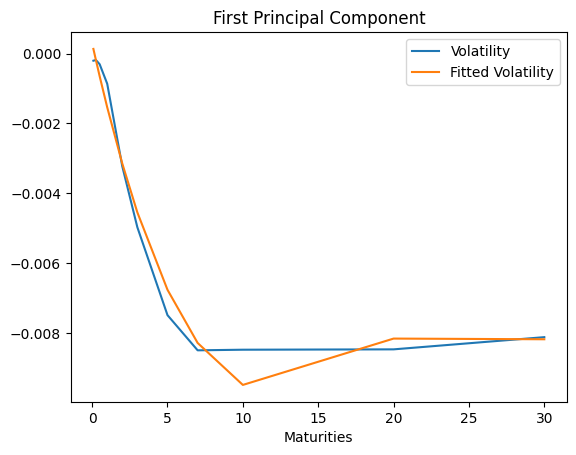

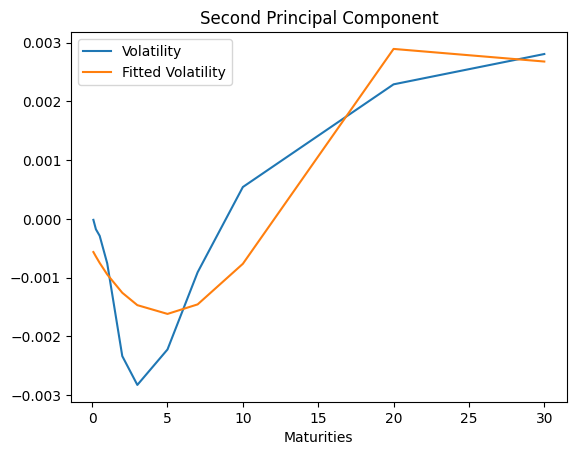

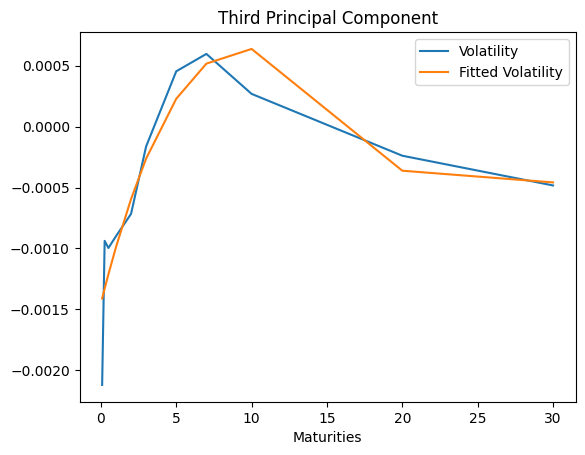

In [ ]:
fitted_vols = []
def fit_vol(idx, degree, title):
    """
    Fit a polynomial of a specified degree to the volatility curve of the idx-th principal component.

    This function plots the original volatility curve and the fitted polynomial curve for comparison,
    then appends the fitted polynomial coefficients to a global list.

    Parameters:
    -----------
    idx : int
        Index of the principal component whose volatility curve is to be fitted.
    degree : int
        Degree of the polynomial to fit to the volatility curve.
    title : str
        Title of the plot for visualization.

    Returns:
    --------
    None
        The function directly plots the results and appends the fitted polynomial coefficients
        to the global list `fitted_vols`.
    """
    vol = vols[:,idx]
    plt.plot(maturities, vol, label='Volatility')
    fitted_vol = np.polyfit(maturities, vol, degree)
    poly = np.poly1d(fitted_vol)
    plt.plot(maturities, poly(maturities), label='Fitted Volatility')
    plt.title(title)
    plt.xlabel('Maturities')
    plt.legend()
    plt.show()
    fitted_vols.append(fitted_vol)

fit_vol(0, 3, 'First Principal Component')
fit_vol(1, 3, 'Second Principal Component')
fit_vol(2, 3, 'Third Principal Component')

We plot all fitted volatilities on the same chart.

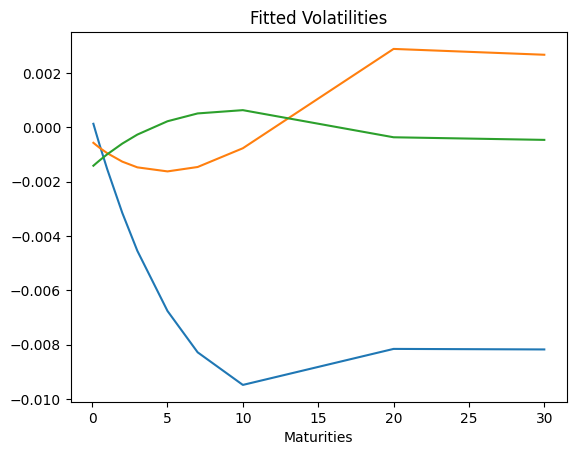

In [32]:
mc_vols = np.array([np.poly1d(fitted_vol)(maturities) for fitted_vol in fitted_vols]).T #get the fitted volatilities for the maturities
plt.plot(maturities, mc_vols) #plot all the fitted volatilities on the same graph
plt.title('Fitted Volatilities')
plt.xlabel('Maturities')
plt.show()  

We calculate the drifts of interest rates with the formula derived in the theoretical section. By noting $s(t,T,\Omega_t)$ the volatility of the process, the drift of the process is : $$m(t,T,\Omega_t) = s(t,T,\Omega_t) \int_t^T s(t,\tau,\Omega_t) d\tau$$

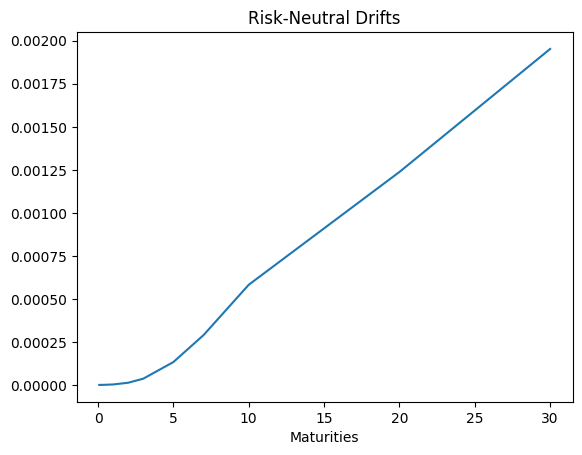

In [38]:
def total_integration(maturity, fitted_vols):
    sum = 0
    for fitted_vol in fitted_vols:
        sum += np.trapz(np.poly1d(fitted_vol)(np.arange(0, maturity, 0.01)), dx=0.01) * np.poly1d(fitted_vol)(maturity)
    return sum

mc_drifts = np.array([total_integration(maturity, fitted_vols) for maturity in maturities])
plt.plot(maturities, mc_drifts)
plt.title('Risk-Neutral Drifts')
plt.xlabel('Maturities')
plt.show()

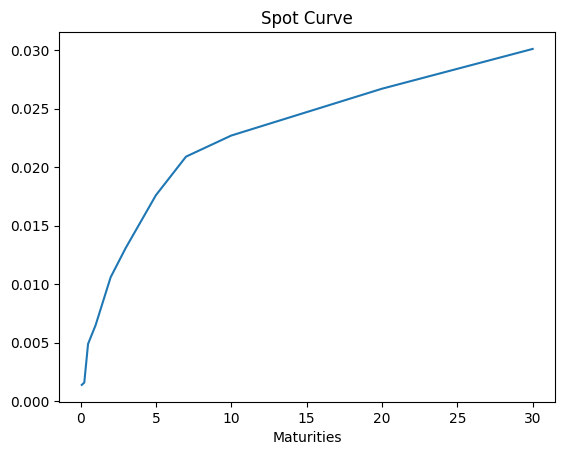

In [39]:
spot_curve = data.iloc[-1].values
plt.plot(maturities, spot_curve)
plt.title('Spot Curve')
plt.xlabel('Maturities')
plt.show()

We create a function that makes a Monte Carlo simulation for the projected rates.

In [ ]:
def monte_carlo_simulation(spot_curve, maturities, drifts, vols, timeline):
    """
    Perform a Monte Carlo simulation of a spot curve over a given timeline.

    This function simulates the evolution of a spot curve using a stochastic process,
    incorporating drift, volatility, and a Brownian motion component. The simulation
    results are returned as a list of tuples, each containing a time point and the
    corresponding spot curve.

    Parameters:
    -----------
    spot_curve : array-like
        Initial spot curve values for each maturity.
    maturities : array-like
        Array of maturity times corresponding to the spot curve.
    drifts : array-like
        Drift terms for each maturity.
    vols : array-like
        Volatility matrix (transposed internally) for each maturity and principal component.
    timeline : array-like
        Array of time points at which the spot curve is simulated.

    Returns:
    --------
    list of tuples
        Each tuple contains a time point and the simulated spot curve at that time.
        The list is ordered chronologically.
    """
    vols = vols.T
    len_maturities = len(maturities)
    len_vols = len(vols)
    results = []
    results.append((timeline[0], copylib.copy(spot_curve)))
    for time_i in range(1, len(timeline)):
        dt = timeline[time_i] - timeline[time_i - 1]
        dW = np.random.normal(0, np.sqrt(dt), len_vols)   
        prev_spot_curve = spot_curve
        spot_curve = copylib.copy(spot_curve)
        for maturity_i in range(len_maturities):
            val = prev_spot_curve[maturity_i] + drifts[maturity_i] * dt
            val += sum([vols[vol_i][maturity_i] * dW[vol_i] for vol_i in range(len_vols)])
            idx = maturity_i+1 if maturity_i+1 < len_maturities else maturity_i-1   # take right difference if possible, else left difference
            spot_curve_diff = (prev_spot_curve[idx] - prev_spot_curve[maturity_i]) / (idx - maturity_i)
            val += spot_curve_diff * dt
            spot_curve[maturity_i] = val
        results.append((timeline[time_i], spot_curve))
    return results

timeline = np.linspace(0, 5, 500)
results = monte_carlo_simulation(spot_curve, maturities, mc_drifts, mc_vols, timeline)
proj_rates = []
for time, rates in results:
    proj_rates.append(rates)
proj_rates = np.array(proj_rates)

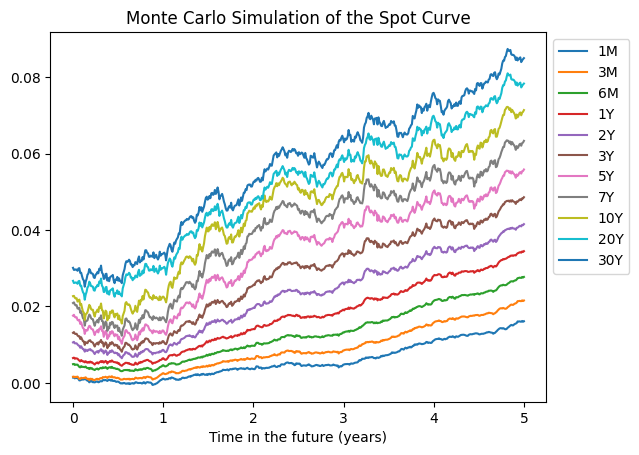

In [45]:
plt.plot(timeline, proj_rates, label=data.columns)
x=[]
for maturity in maturities:
    if maturity<=timeline[-1]:
        x.append(maturity)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust bbox_to_anchor to position the legend
plt.xlabel('Time in the future (years)')
plt.title('Monte Carlo Simulation of the Spot Curve')
plt.show()

We apply the previous work on a caplet valuation. We iterate the Monte Carlo simulations and calculate the present value of the caplet for each path. Then, we plot the convergence process (the mean of present values for the previous paths) that converges to the caplet price.

In [46]:
t_exp, t_mat = 1., 2.   # Time to expiration of the caplet and maturity of the underlying rate
K, notional = .005, 1e6 # Strike and notional of the caplet
n_simulations, n_timesteps = 500, 50

proj_timeline = np.linspace(0,t_mat, n_timesteps) #Timeline until maturity
simulated_pvs = []      # Present values
pvs_mean = [] # Convergence process of the present values
for _ in range(0, n_simulations):
    discount_rate_sum = 0       # sum of the discount rates for this path
    discount_rate_n = 0         # number of discount rates in the sum
    for t, curve_fwd in monte_carlo_simulation(spot_curve, maturities, mc_drifts, mc_vols, proj_timeline):
        discount_rate_sum += np.interp(0., maturities, curve_fwd)  # instantaneous rate at time t calibrated with the curve created by the MC simulation
        discount_rate_n += 1
        if t>=t_exp: 
            Tau = t_mat-t_exp
            # integrate all forward rates from 0 to Tau
            rate_forecast_sum = 0   # sum of the forward rates
            rate_forecast_n = 0     # number of forward rates in the sum
            for s in np.linspace(0, Tau, 15): 
                rate_forecast_sum += np.interp(s, maturities, curve_fwd)
                rate_forecast_n += 1
            rate_forecast = Tau * rate_forecast_sum / rate_forecast_n 
    df = np.exp(- t_exp * discount_rate_sum / discount_rate_n)   # Discount factor
    pv = max(0, rate_forecast - K) * (t_mat-t_exp) * notional * df  # Present value 
    simulated_pvs.append(pv)
    pvs_mean.append(np.mean(simulated_pvs))

Final value: 4723.418270


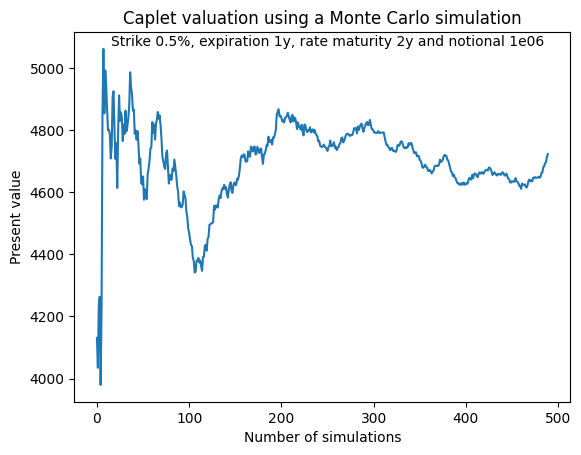

In [47]:
plt.plot(pvs_mean[10:])
plt.xlabel('Number of simulations')
plt.ylabel('Present value')
plt.title('Caplet valuation using a Monte Carlo simulation')
plt.text(x=n_simulations/2, y=np.max(pvs_mean[10:]), s="Strike %.1f%%, expiration %.0fy, rate maturity %.0fy" % (K*100, t_exp, t_mat) + " and notional {:.0e}".format(notional).replace('+',''),ha='center', va='bottom')
print("Final value: %f" % pvs_mean[-1])

We can see from the above chart that our value process is converging because the changes become smaller.

## References
- D. Heath, R. A. Jarrow, and A. Morton, "Bond Pricing and the Term Structure of Interest Rates: A New Methodology" Econometrica, 60, 1 (1992): 77–105
- J.C. Hull, Options, Futures, and Other Derivatives. 11th ed. Boston: Pearson, 2021 (Chapter 33)
- A. De la Rosa, [online article on Medium](https://medium.com/@aaron_delarosa/heath-jarrow-morton-hjm-model-7a16b7f56daf)